In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve
from catboost import CatBoostClassifier
from mofapy2.run.entry_point import entry_point
import h5py

import sys
sys.path.append("..")

from src.tcga_preprocess_utils import handle_duplicates, prepare_data, choose_common_patients
from src.mofa_utils import transform_df_for_mofa

In [ ]:
RANDOM_STATE = 42

Выживаемость:

In [85]:
survival_data = pd.read_csv('data/breast/survival', sep='\t')
survival_data['PatientID'] = survival_data['PatientID'].str.lower()

survival_data

,PatientID,Survival,Death
0,tcga.ol.a66h,812.0,0.0
1,tcga.3c.aalk,1448.0,0.0
2,tcga.ar.a1ah,3807.0,0.0
3,tcga.ac.a5eh,511.0,0.0
4,tcga.ew.a2fw,672.0,0.0
...,...,...,...
1224,tcga.bh.a1f0,785.0,1.0
1225,tcga.a8.a06q,31.0,0.0
1226,tcga.5l.aat0,1477.0,0.0
1227,tcga.e9.a245,NaN,NaN


*Убираем дубликаты и Death == NaN*

In [87]:
survival_data = handle_duplicates(survival_data)
survival_data = survival_data.dropna(subset=['Death'])
survival_data = survival_data.set_index('PatientID')

survival_data

,Survival,Death
PatientID,,
tcga.ol.a66h,812.0,0.0
tcga.3c.aalk,1448.0,0.0
tcga.ar.a1ah,3807.0,0.0
tcga.ac.a5eh,511.0,0.0
tcga.ew.a2fw,672.0,0.0
...,...,...
tcga.e9.a3ho,1158.0,0.0
tcga.d8.a27e,530.0,0.0
tcga.ar.a24q,3172.0,0.0


In [89]:
expression_data = prepare_data('data/breast/exp', survival_data.index)

expression_data

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,C17orf49|124944,C17orf50|146853,C17orf51|339263,C17orf53|78995,C17orf54|283982,C17orf55|284185,C17orf56|146705,C17orf57|124989,C17orf58|284018,C17orf59|54785
tcga.3c.aaau,0.0000,16.3644,12.9316,52.1503,408.0760,0.0,1187.0050,0.0000,0.0000,0.0,...,607.3922,2.4126,261.5960,110.2908,0.0000,13.7864,634.2170,33.0872,477.3525,209.8972
tcga.3c.aali,0.0000,9.2659,17.3790,69.7553,563.8934,0.0,516.0413,1.0875,0.5438,0.0,...,906.5470,17.9445,65.7966,127.7868,1.6313,50.5710,942.4470,64.7091,4373.5726,286.5688
tcga.3c.aalj,0.9066,11.6228,9.2294,154.2974,1360.8341,0.0,592.0218,0.0000,0.0000,0.0,...,974.2248,0.0000,115.1405,95.1949,0.0000,108.7942,823.4180,24.4787,836.8087,295.5576
tcga.3c.aalk,0.0000,12.0894,11.0799,143.8643,865.5358,0.0,552.7513,0.4137,0.0000,0.0,...,1012.8796,0.4137,100.1241,49.2346,0.8275,16.1357,728.1051,22.3417,1208.1092,156.3922
tcga.4h.aaak,0.0000,6.8468,14.4298,84.2128,766.3830,0.0,260.8511,0.4255,0.0000,0.0,...,1019.9106,0.4255,125.9574,91.0638,0.4255,5.9574,521.4936,69.7872,572.3404,162.5532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tcga.wt.ab44,0.0000,0.0000,3.2580,42.2643,1877.4180,0.0,704.5408,4.0725,0.0000,0.0,...,1784.1091,0.8145,111.5862,54.5714,0.0000,5.7015,713.9971,19.7271,1042.5575,NaN
tcga.xx.a899,0.0000,14.3858,21.4409,137.7756,652.7559,0.0,427.1654,2.7559,0.0000,0.0,...,863.2874,2.7559,196.8504,75.5906,0.3937,16.9291,548.7165,75.9843,256.6929,NaN
tcga.xx.a89a,0.0000,22.3240,27.2744,64.1427,722.7208,0.0,376.4761,0.4724,0.0000,0.0,...,847.7563,0.0000,233.3491,75.5786,0.0000,9.9197,397.7468,24.0907,213.5097,NaN
tcga.z7.a8r5,0.0000,2.2638,7.2933,85.0461,1140.2801,0.0,252.0682,0.5973,0.0000,0.0,...,2447.4330,4.1812,131.4100,46.5908,0.0000,24.4900,625.0575,15.3093,411.5521,NaN


In [90]:
methylation_data = prepare_data('data/breast/methy', survival_data.index)

methylation_data

,cg00001583,cg00001747,cg00002719,cg00011616,cg00013655,cg00025347,cg00034076,cg00036011,cg00041599,cg00043510,...,cg06350853,cg06351537,cg06355129,cg06358322,cg06358671,cg06360976,cg06368401,cg06371502,cg06374079,cg06377278
tcga.3c.aaau,0.242943,0.031749,0.516227,0.941399,0.050625,0.254999,0.044503,0.055939,0.616213,0.778279,...,0.434350,0.095317,0.928284,0.187007,0.863182,0.887695,0.283930,0.196000,0.208392,0.023357
tcga.3c.aali,0.020153,0.057154,0.783211,0.935964,0.623837,0.259896,0.221409,0.052228,0.531149,0.860384,...,0.496708,0.168599,0.453676,0.332331,0.928037,0.183673,0.429683,0.426238,0.026622,0.017834
tcga.3c.aalj,0.462715,0.057074,0.697199,0.948888,0.625223,0.685907,0.140006,0.074468,0.529818,0.791711,...,0.794737,0.300184,0.846229,0.635042,0.873782,0.262445,0.399614,0.698144,0.570438,0.553052
tcga.3c.aalk,0.541054,0.545638,0.674409,0.184844,0.766111,0.537981,0.215374,0.513302,0.678906,0.669661,...,0.571301,0.452955,0.735176,0.664027,0.543986,0.462372,0.466789,0.333208,0.487907,0.455653
tcga.4h.aaak,0.515059,0.616939,0.617353,0.114255,0.050625,0.537234,0.234295,0.085008,0.582798,0.279028,...,0.675045,0.362002,0.690358,0.527925,0.574184,0.887695,0.460537,0.126453,0.434574,0.484465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tcga.wt.ab44,0.672427,0.695487,0.441444,0.132223,0.050625,0.464096,0.240594,0.370710,0.810678,0.725528,...,0.112834,0.665660,0.812746,0.796415,0.108761,0.851075,0.428617,0.469237,0.633826,NaN
tcga.xx.a899,0.294309,0.517730,0.372236,0.394446,0.534657,0.424254,0.093658,0.054086,0.496727,0.665695,...,0.737854,0.826489,0.618353,0.871387,0.869127,0.758546,0.656972,0.240735,0.370509,NaN
tcga.xx.a89a,0.367615,0.369683,0.451676,0.797703,0.050625,0.513636,0.075868,0.062335,0.176822,0.483907,...,0.531762,0.472082,0.710533,0.486623,0.286902,0.562610,0.649800,0.057343,0.058958,NaN
tcga.z7.a8r5,0.304950,0.077868,0.377488,0.271380,0.600615,0.749884,0.308027,0.242278,0.344770,0.413290,...,0.463389,0.484338,0.507505,0.719476,0.626227,0.867525,0.763142,0.311798,0.363750,NaN


In [91]:
mirna_data = prepare_data('data/breast/mirna', survival_data.index)

mirna_data

,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-941-3,hsa-mir-941-4,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
tcga.3c.aaau,8962.996542,17779.575039,9075.200383,24749.898857,341.298400,406.164781,1470.179650,14.716795,3627.642977,387.417272,...,0.0,0.0,5.530515,0.187475,2.062226,4.124452,119.984057,53.992826,130.201449,46548.939810
tcga.3c.aali,7739.739862,15524.941906,7713.626636,23374.640471,801.487258,513.297924,560.962427,20.922042,6557.093894,350.955461,...,0.0,0.0,8.180047,0.000000,0.629234,1.258469,60.249189,86.047798,236.434808,12644.149725
tcga.3c.aalj,8260.612670,16497.981335,8355.342958,10957.355911,635.811272,620.351816,2694.331127,39.799878,11830.760394,600.725980,...,0.0,0.0,3.618171,0.000000,0.767491,1.644623,97.252043,117.645369,191.434123,33083.456616
tcga.3c.aalk,9056.241254,18075.168478,9097.666150,26017.522731,2919.348415,334.245155,1322.434475,17.866463,6438.725384,354.957604,...,0.0,0.0,3.478426,0.000000,3.478426,1.739213,72.572624,41.583007,1046.690127,24067.232290
tcga.4h.aaak,10897.303665,21822.338727,10963.956320,22204.253575,3313.009950,350.615669,1711.886682,22.541895,8246.117280,333.425447,...,0.0,0.0,2.108235,0.000000,1.135203,0.810860,19.947145,34.380445,1081.037952,25715.275426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tcga.wt.ab44,10628.975280,21125.108661,10585.686678,23396.813364,3892.051211,367.141461,1484.663795,23.402901,10570.535667,571.680109,...,0.0,0.0,1.217492,0.000000,0.405831,1.217492,79.813361,57.627952,1100.883277,16338.471420
tcga.xx.a899,16799.785282,33603.904432,16883.338223,20731.006597,5263.331356,201.676038,2173.283559,36.888271,18227.341203,870.301142,...,0.0,0.0,5.341744,0.000000,3.124416,2.318115,16.629958,57.348159,1919.601107,14080.736733
tcga.xx.a89a,13120.807001,26337.935723,13229.425112,18796.895124,6581.549565,375.598820,2547.029500,28.505268,16838.042944,778.398745,...,0.0,0.0,1.863089,0.000000,0.558927,0.931545,41.919511,54.215901,1310.124456,17072.605898
tcga.z7.a8r5,7979.531224,16006.280243,8106.687917,20462.010937,4040.296936,295.594442,962.166120,23.885025,7625.121634,428.411748,...,0.0,0.0,2.070956,0.000000,2.209020,1.656765,55.225491,53.016472,1120.939408,18696.866174


*Теперь во всех оставляем только пациентов, встречающихся во всех 4х датасетах*

In [93]:
survival_data, expression_data, methylation_data, mirna_data = choose_common_patients(
    survival_data, expression_data, methylation_data, mirna_data)


target_death= survival_data['Death']
target_survival = survival_data['Survival']

In [94]:
print('Всего пациентов: ', expression_data.shape[0])

Всего пациентов:  620


1. PCA + CatBoost (?)

2. PCA + LightAutoML (?)

3. MOFA

Преобразовываем под нужный формат данных

In [96]:
transformed_expression_data = transform_df_for_mofa(expression_data.copy(), 'DNA')


transformed_expression_data['value'] = transformed_expression_data['value'] /transformed_expression_data['value'].abs().max() 

transformed_methylation_data = transform_df_for_mofa(methylation_data.copy(), 'Methylation')
transformed_methylation_data['value'] = transformed_methylation_data['value'] /transformed_methylation_data['value'].abs().max() 

transformed_mirna_data = transform_df_for_mofa(mirna_data.copy(), 'RNA')
transformed_mirna_data['value'] = transformed_mirna_data['value'] /transformed_mirna_data['value'].abs().max() 

combined_data = pd.concat([transformed_expression_data, transformed_methylation_data, transformed_mirna_data], axis=0)

combined_data

,sample,feature,value,view
0,tcga.3c.aaau,?|100130426,0.000000e+00,DNA
1,tcga.3c.aali,?|100130426,0.000000e+00,DNA
2,tcga.3c.aalj,?|100130426,6.852871e-07,DNA
3,tcga.3c.aalk,?|100130426,0.000000e+00,DNA
4,tcga.4h.aaak,?|100130426,0.000000e+00,DNA
...,...,...,...,...
648515,tcga.wt.ab44,hsa-mir-99b,2.388456e-02,RNA
648516,tcga.xx.a899,hsa-mir-99b,2.058407e-02,RNA
648517,tcga.xx.a89a,hsa-mir-99b,2.495776e-02,RNA
648518,tcga.z7.a8r5,hsa-mir-99b,2.733221e-02,RNA


Обучаем модель

In [102]:
ent = entry_point()


# (2) Set data options
# - scale_views: if views have very different ranges, one can to scale each view to unit variance
ent.set_data_options(
    scale_views=False
)

# (3) Set data using the data frame format
ent.set_data_df(combined_data)

# using default values
ent.set_model_options()

# using personalised values
ent.set_model_options(
    factors=10,
    spikeslab_weights=True,
    ard_weights=True
)

## (5) Set training options ##
# - iter: number of iterations
# - convergence_mode: "fast", "medium", "slow". Fast mode is usually good enough.
# - dropR2: minimum variance explained criteria to drop factors while training. Default is None, inactive factors are not dropped during training
# - gpu_mode: use GPU mode? this functionality needs cupy installed and a functional GPU, see https://biofam.github.io/MOFA2/gpu_training.html
# - seed: random seed

# using default values
ent.set_train_options()

# using personalised values
ent.set_train_options(
    iter=10000,
    convergence_mode="slow",
    dropR2=None,
    gpu_mode=False,
    seed=42
)

####################################
## Build and train the MOFA model ##
####################################

# Build the model
ent.build()

# Run the model
ent.run()

####################
## Save the model ##
####################

outfile = "test.hdf5"

# - save_data: logical indicating whether to save the training data in the hdf5 file.
# this is useful for some downstream analysis in R, but it can take a lot of disk space.
ent.save(outfile, save_data=True)

#########################
## Downstream analysis ##
#########################

# Check the mofax package for the downstream analysis in Python: https://github.com/bioFAM/mofax
# Check the MOFA2 R package for the downstream analysis in R: https://www.bioconductor.org/packages/release/bioc/html/MOFA2.html
# All tutorials: https://biofam.github.io/MOFA2/tutorials.html

# Extract factor values (a list with one matrix per sample group)
factors = ent.model.nodes["Z"].getExpectation()

# Extract weights  (a list with one matrix per view)
weights = ent.model.nodes["W"].getExpectation()

# Extract variance explained values
r2 = ent.model.calculate_variance_explained()

# Interact directly with the hdf5 file
f = h5py.File(outfile, 'r')


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded group='single_group' view='DNA' with N=620 samples and D=2024 features...
Loaded group='single_group' view='Methylation' with N=620 samples and D=1210 features...
Loaded group='single_group' view='RNA' with N=620 samples and D=1046 features...




Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on 

OSError: Unable to synchronously create file (unable to truncate a file which is already open)

In [ ]:
plt.scatter(factors[:, 2], factors[:, 1], c=target_death.values, label='Death');

Посмотрим можно ли предсказать таргет с помощью факторов

In [103]:
X_train, X_test, y_train, y_test = train_test_split(factors, target_death, test_size=0.25, random_state=RANDOM_STATE, stratify=target_death)

In [105]:
cb_classifier = CatBoostClassifier(n_estimators=5000, random_state=RANDOM_STATE, silent=True)
cb_classifier.fit(X_train, y_train)
y_pred = cb_classifier.predict(X_test)

Learning rate set to 0.001698
0:	learn: 0.6917192	total: 3.33ms	remaining: 16.7s
1:	learn: 0.6903678	total: 5.03ms	remaining: 12.6s
2:	learn: 0.6889767	total: 6.55ms	remaining: 10.9s
3:	learn: 0.6875983	total: 9.43ms	remaining: 11.8s
4:	learn: 0.6862275	total: 15.7ms	remaining: 15.7s
5:	learn: 0.6848945	total: 16.7ms	remaining: 13.9s
6:	learn: 0.6835625	total: 17.5ms	remaining: 12.5s
7:	learn: 0.6821996	total: 18.2ms	remaining: 11.4s
8:	learn: 0.6808563	total: 19ms	remaining: 10.5s
9:	learn: 0.6795943	total: 19.8ms	remaining: 9.86s
10:	learn: 0.6782589	total: 20.6ms	remaining: 9.36s
11:	learn: 0.6769420	total: 21.5ms	remaining: 8.93s
12:	learn: 0.6755280	total: 22.3ms	remaining: 8.56s
13:	learn: 0.6742243	total: 23.1ms	remaining: 8.23s
14:	learn: 0.6729311	total: 24ms	remaining: 7.98s
15:	learn: 0.6715885	total: 24.9ms	remaining: 7.75s
16:	learn: 0.6703072	total: 25.8ms	remaining: 7.55s
17:	learn: 0.6688414	total: 26.6ms	remaining: 7.37s
18:	learn: 0.6674479	total: 27.4ms	remaining: 7.

In [106]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f'Accuracy: {accuracy}, F1: {f1}')

Accuracy: 0.8709677419354839, F1: 0.0


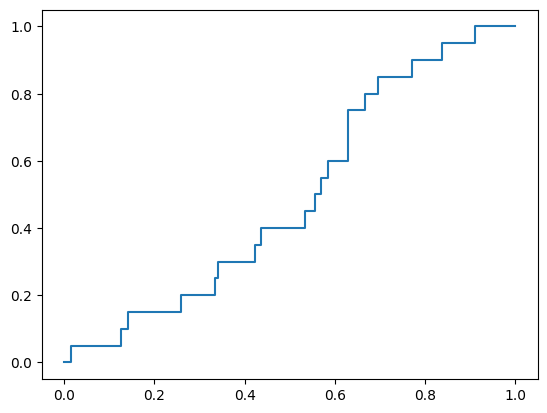

In [107]:
y_probas = cb_classifier.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test.values, y_probas[:, 1])

plt.plot(fpr, tpr)
plt.title('ROC curve');